# Noise2Void - 3D Example

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Using TensorFlow backend.


# Download Example Data
Thanks to Romina Piscitello (Eaton Lab, MPI-CBG) for letting us use her data.

# Training Data Preparation
For training we will load __one__ low-SNR 3D-tif-volume and use the <code>N2V_DataGenerator</code> to extract non-overlapping 3D-patches. Since N2V is a self-supervised method, we don't need targets.

In [2]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [3]:
# We will load all the '.tif' files from the 'data' directory. In our case it is only one.
# The function will return a list of images (numpy arrays).
# In the 'dims' parameter we specify the order of dimensions in the image files we are reading.
imgs = datagen.load_imgs_from_directory(directory = "data/b")

# Let's look at the shape of the image
print(imgs[0].shape,imgs[1].shape)
print(len(imgs))
# The function automatically added two extra dimension to the images:
# One at the front is used to hold a potential stack of images such as a movie.
# One at the end could hold color channels such as RGB.

(1, 4096, 4096, 1) (1, 4096, 4096, 1)
2


In [4]:
len(imgs)
%matplotlib inline

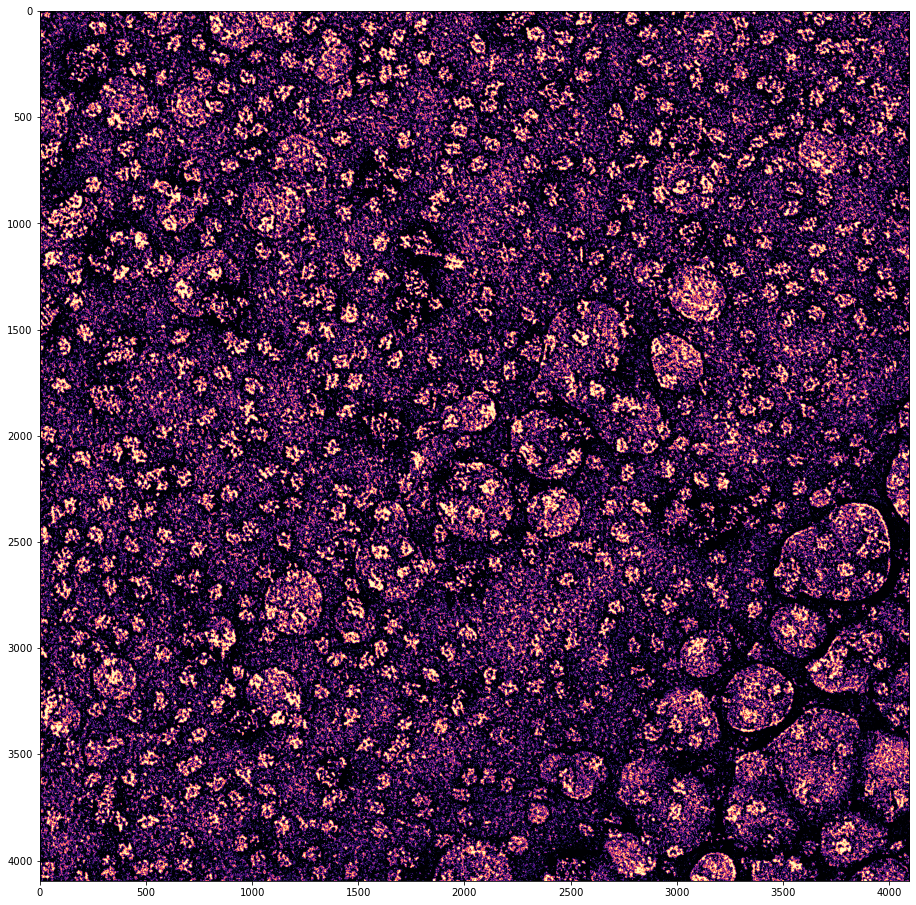

In [5]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.

index = 0
plt.figure(figsize=(32,16))
plt.imshow(imgs[index][0,...,0], 
           cmap='magma',
#            vmin=20000,
#            vmax=22000,
           vmin=np.percentile(imgs[index],0.1),
           vmax=np.percentile(imgs[index],99.1)
          )
plt.show()

In [6]:
# Here we extract patches for training and validation.
patch_shape = (128, 128)
X = datagen.generate_patches_from_list(imgs[:1], shape=patch_shape)
X_val = datagen.generate_patches_from_list(imgs[1:], shape=patch_shape)

Generated patches: (8192, 128, 128, 1)
Generated patches: (8192, 128, 128, 1)


In [7]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
# X = patches[:600]
# X_val = patches[600:]

In [11]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

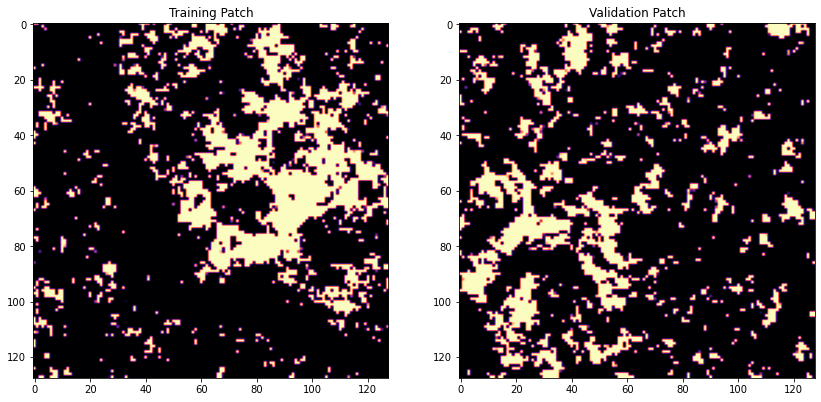

In [8]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
__Note:__ Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [9]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=20, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['14281.453'],
 'stds': ['26962.857'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 64,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'structN2Vmask': None,
 'probabilistic': False}

In [10]:
# a name used to identify the model
model_name = 'n2v_Dmitry-B'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

## Training

In [11]:
history = model.train(X, X_val)


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 8192/8192 [00:06<00:00, 1200.43it/s]




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/20
64/64 [==============================] - 269s 4s/step - loss: 0.6494 - n2v_mse: 0.6494 - n2v_abs: 0.5208 - val_loss: 0.5518 - val_n2v_mse: 0.5518 - val_n2v_abs: 0.4733

Epoch 2/20
64/64 [==============================] - 278s 4s/step - loss: 0.4524 - n2v_mse: 0.4524 - n2v_abs: 0.3997 - val_loss: 0.4440 - val_n2v_mse: 0.4440 - val_n2v_abs: 0.3983
Epoch 3/20
64/64 [==============================] - 283s 4s/step - loss: 0.4331 - n2v_mse: 0.4331 - n2v_abs: 0.3815 - val_loss: 0.4311 - val_n2v_mse: 0.4311 - val_n2v_abs: 0.3753
Epoch 4/20
64/64 [==============================] - 283s 4s/step - loss: 0.4212 - n2v_mse: 0.

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


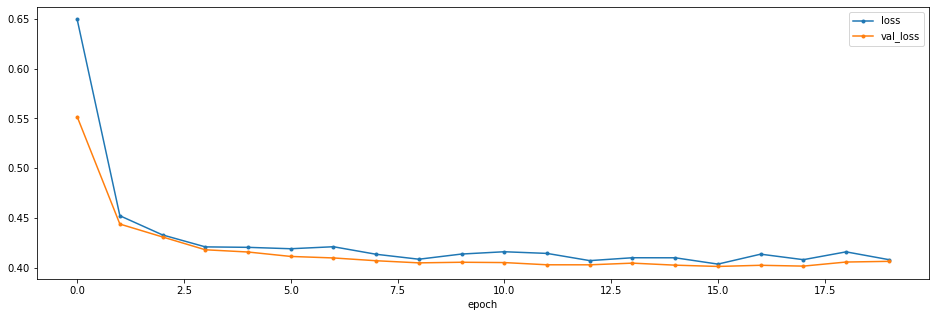

In [12]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [13]:
model.export_TF(name='Noise2Void - Dmitry B', 
                description='Noise2Void Dmitry B micrograms.', 
                authors=["João Mamede","Dmitry Lyumkis"],
                test_img=X_val[0,...,0], axes='YX',
                patch_shape=patch_shape)



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpajewlsp8/model/saved_model.pb

Model exported in BioImage ModelZoo format:
/home/jmamede/scripts/notebooks/n2v/models/n2v_Dmitry-B/export.bioimage.io.zip
